In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime,timedelta
mta_data = pd.read_pickle('mta_data.pickle')

#reset index and drop old indices to remove duplicate indexes and fix cols; remove duplicates
mta_data = mta_data.reset_index().drop('index',axis=1)
mta_data.columns = [col.strip() for col in mta_data.columns]
mta_data.drop_duplicates(inplace=True)

# convert dates to datetime, create col; convert that to day of week, create col; convert that to weekday T/F, create col
mta_data['weekday'] = pd.to_datetime(mta_data.DATE,format='%m/%d/%Y')
mta_data['weekday_n'] = mta_data.weekday.dt.dayofweek
mta_data['weekday_tf'] = mta_data.weekday_n<5

#create columns for entries since last time
mta_data['peop_in'] = mta_data.groupby(['weekday','SCP'])['ENTRIES'].diff(periods = 1)
mta_data['peop_out'] = mta_data.groupby(['weekday','SCP'])['EXITS'].diff(periods = 1)
mta_data.fillna(0,inplace=True)

#filter the weird values and fill nan
mta_data.peop_out[mta_data['peop_out']<0] = 0
mta_data.peop_in[mta_data['peop_in']<0] = 0
mta_data.peop_out[mta_data['peop_out']>4000] = 0
mta_data.peop_in[mta_data['peop_in']>4000] = 0
mta_data.fillna(0)

#drop values where there is nobody in/out that we have fewer rows
mta_data.drop(mta_data[mta_data['peop_in']==0].index,inplace=True)
mta_data.drop(mta_data[mta_data['peop_out']==0].index,inplace=True)

#find sum of data and the total number of people through by day
sum_d = mta_data.groupby(['STATION','weekday']).sum()
sum_d['through']=sum_d.peop_in+sum_d.peop_out
sum_d.reset_index(inplace=True)

#Create new row in order to fix issue with adding t/f values and calculate dif in mean on weekday v weekend
sum_d['weekend_tf'] = sum_d.weekday_tf == 0
sum_d_m = sum_d.groupby(['STATION','weekend_tf']).mean()
sum_d_m.reset_index(inplace=True)
sum_d_m['mean_dif']=sum_d_m.groupby("STATION").diff(periods=1).through

#select only 1 value for each, because diff is unreliable
mean_difs = sum_d_m[sum_d_m.weekend_tf == True]

#remove NA and find 10 worst stations (more traffic on weekend=touristy)
top10b = mean_difs.sort_values(by='mean_dif').head(10)

#plot those 10
plt.figure(figsize=(10,10))
plt.bar(x=top10b.STATION,height=top10b.mean_dif)
plt.xticks(rotation=90)
plt.title('Most Touristy Stations')
plt.xlabel('Station Name')
plt.ylabel('Difference in People on Weekends/Weekdays')
plt.show();

#remove NA and find 10 best stations (more traddic on weekdays = commuter)
top10g = mean_difs.sort_values(by='mean_dif',ascending=False).head(10)

#plot those 10
plt.figure(figsize=(10,10))
plt.bar(x=top10g.STATION,height=top10g.mean_dif)
plt.xticks(rotation=90)
plt.title('Least Touristy Stations')
plt.xlabel('Station Name')
plt.ylabel('Difference in People on Weekends/Weekdays')
plt.show();

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

In [57]:
tourist_ratio = sum_d
tourist_ratio = sum_d.drop(['ENTRIES','EXITS','weekday_n','weekday_tf','peop_in','peop_out'],axis=1)

In [58]:
tourist_ratio = tourist_ratio.sort_values('weekend_tf').groupby(['STATION','weekend_tf']).mean()
tourist_ratio[tourist_ratio.through>0]
tourist_ratio.iloc[::-1]
#ratio every other row shows 1 - weekend mean/weekday mean, so higher = more commuter
# 1/ bc want the lower values to be higher
tourist_ratio['ratio']=tourist_ratio.through.pct_change()

In [59]:
tourist_ratio.reset_index(inplace=True)

In [60]:
ratio_table = tourist_ratio[tourist_ratio.weekend_tf==True]
ratio_table.reset_index(inplace=True)
ratio_table.set_index('STATION',inplace=True)
ratio_table.drop(['weekend_tf','through'],axis=1,inplace=True)

In [61]:
ratio_table.head(5)

,index,ratio
STATION,,
1 AV,1,-0.333892
103 ST,3,-0.467148
103 ST-CORONA,5,-0.369953
104 ST,7,-0.604938
110 ST,9,-0.451196


In [72]:
station_ratio_through = mta_data.groupby(['STATION','weekday_tf']).sum()[1::2]

In [73]:
station_ratio_through

,,ENTRIES,EXITS,weekday_n,peop_in,peop_out
STATION,weekday_tf,,,,,
1 AV,True,2606530034817,1980023382309,25197,5014871.0,5080370.0
103 ST,True,188460504559,747973851493,36955,7693278.0,4403412.0
103 ST-CORONA,True,86267371993,84002952914,23670,4991912.0,2964115.0
104 ST,True,18655702366,16166510263,14151,833556.0,297228.0
110 ST,True,39263300741,39655464038,15360,3091723.0,2187425.0
111 ST,True,92737920670,61287935076,35291,4178660.0,1990482.0
116 ST,True,555726651224,565935300748,53178,8513699.0,4089153.0
116 ST-COLUMBIA,True,1474967531972,315048581850,15181,3582724.0,1894833.0
121 ST,True,16270097754,7519273419,11044,383594.0,161255.0


In [74]:
station_ratio_through.reset_index(inplace=True)

In [75]:
station_ratio_through = station_ratio_through.set_index("STATION").join(ratio_table)

In [76]:
#divide through to prevent scientific notation/dumb scores
station_ratio_through['through'] = (station_ratio_through.peop_in+station_ratio_through.peop_out)/10000000

In [77]:
station_ratio_through.describe() #ADD 1 TO ALL RATIOS BC OTHERWISE WEIRD

,ENTRIES,EXITS,weekday_n,peop_in,peop_out,index,ratio,through
count,3.790000e+02,3.790000e+02,379.000000,3.790000e+02,3.790000e+02,379.000000,379.000000,379.000000
mean,3.293739e+11,2.421055e+11,26738.588391,3.530772e+06,2.586389e+06,379.060686,-0.477173,0.611716
std,8.217610e+11,6.363682e+11,27759.431329,4.904164e+06,4.270645e+06,219.203208,0.166492,0.912148
min,1.696788e+07,3.887700e+05,176.000000,4.630000e+02,3.710000e+02,1.000000,-0.887235,0.000094
25%,1.510542e+10,1.032434e+10,10278.500000,9.678920e+05,5.343735e+05,190.000000,-0.565981,0.159108
50%,4.136612e+10,2.562950e+10,18446.000000,1.882657e+06,1.191494e+06,379.000000,-0.482756,0.305484
75%,1.825157e+11,8.661408e+10,30409.000000,4.070008e+06,2.649185e+06,568.000000,-0.413205,0.679845
max,5.440548e+12,4.899108e+12,237125.000000,4.079560e+07,3.473014e+07,758.000000,0.832076,7.552574


In [82]:
station_ratio_through = station_ratio_through[station_ratio_through.through>.1]

In [87]:
station_ratio_through['score'] = .7*station_ratio_through.ratio * .3*station_ratio_through.through

In [97]:
top20_rt = station_ratio_through.sort_values(by='score').head(20)
top20_rt.score = top20_rt.score*-1

In [98]:
top20_rt.reset_index(inplace=True)

In [115]:
top20_rt

,STATION,weekday_tf,ENTRIES,EXITS,weekday_n,peop_in,peop_out,index,ratio,through,score
0,GRD CNTRL-42 ST,True,2455894346970,976161637887,135675,36892914.0,31738421.0,467,-0.683060,6.863133,0.984465
1,34 ST-PENN STA,True,4047882746090,2815862717484,237125,40795602.0,34730135.0,123,-0.545157,7.552574,0.864641
2,FULTON ST,True,4501503634576,3165855514758,197948,23155450.0,19598388.0,453,-0.685980,4.275384,0.615894
3,23 ST,True,4886799950564,4139552233203,154718,27431058.0,21405209.0,93,-0.593412,4.883627,0.608581
4,34 ST-HERALD SQ,True,2064109775151,1714115125831,128547,26773215.0,25636334.0,119,-0.516442,5.240955,0.568396
5,47-50 STS ROCK,True,2422880552574,2457760455930,82085,13970007.0,15861045.0,145,-0.753262,2.983105,0.471882
6,86 ST,True,1771440035745,832194236358,124445,22426929.0,18132154.0,221,-0.470181,4.055908,0.400473
7,CHAMBERS ST,True,4913262673041,3275845043768,121650,16150403.0,11755156.0,361,-0.671180,2.790556,0.393323
8,TIMES SQ-42 ST,True,5074964480874,2321254681753,121800,21221381.0,21689723.0,711,-0.432432,4.291110,0.389679
9,14 ST-UNION SQ,True,1391839736379,463253926945,93363,23785684.0,22913867.0,29,-0.383689,4.669955,0.376281


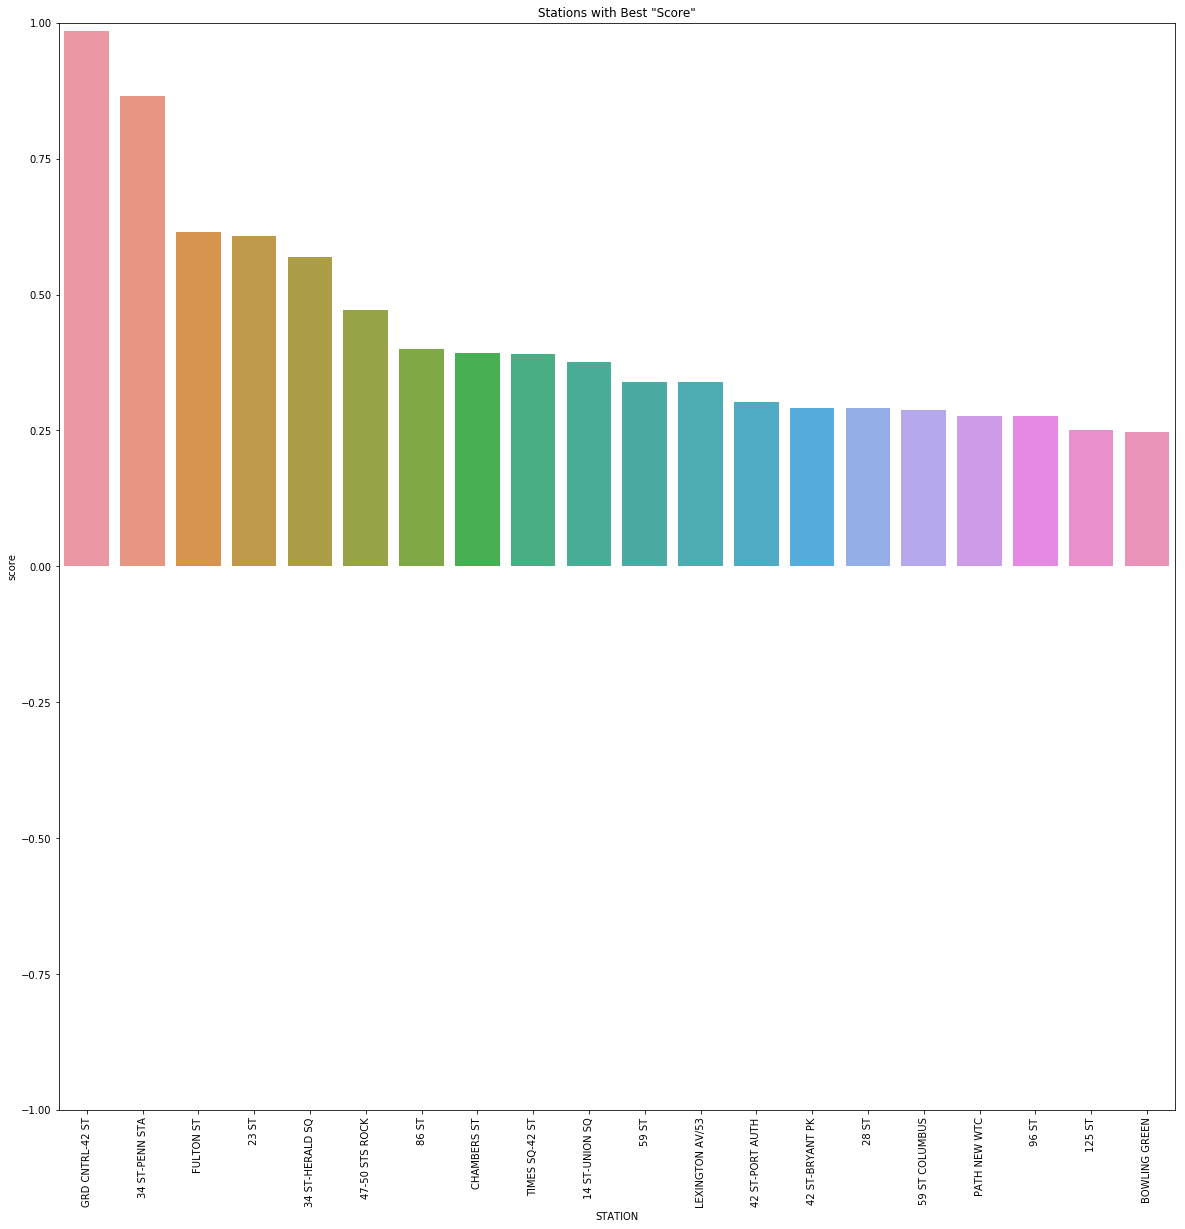

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure (figsize=(20,20))
plt.ylim((-1,1))
plt.xticks(rotation=90)
plt.title('Stations with Best "Score"')
sns.barplot(x='STATION', y='score', data = top20_rt)

In [125]:
bottom20_rt = station_ratio_through.sort_values(by='score',ascending=False).head(20)

In [126]:
bottom20_rt.reset_index(inplace = True)

In [128]:
bottom20_rt['score'] = bottom20_rt.score*-1

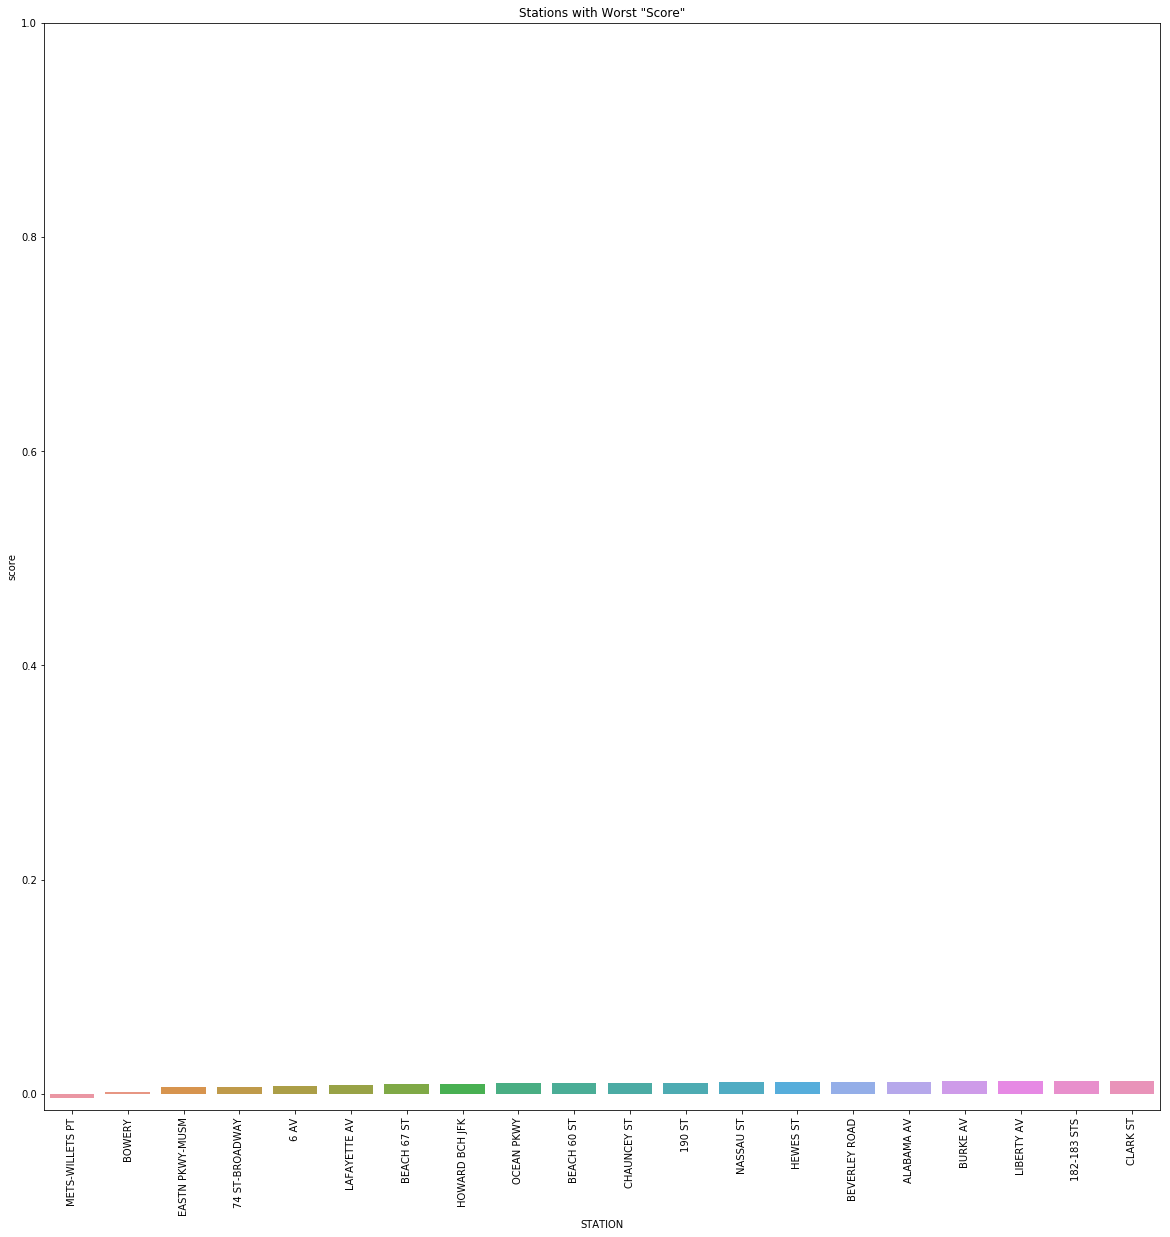

In [129]:
plt.figure (figsize=(20,20))
plt.xticks(rotation=90)
plt.ylim((-.015,1))
plt.title('Stations with Worst "Score"')
sns.barplot(x='STATION', y='score', data = bottom20_rt)

In [125]:
good_scores = station_ratio_through[station_ratio_through.ratio>3]

In [203]:
good_traffratio = good_scores[good_scores.through>.15]

In [85]:
good_traffratio.sort_values(by='score',ascending=False).head(10)

NameError: name 'good_traffratio' is not defined

In [ ]:
#drop sports